In [4]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('data/data.csv')

# Convert 'date' to datetime format and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data.head(), data.tail(), data.info()

In [ ]:


# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Impute missing values in 'exog' for the whole dataset
data['exog'] = knn_imputer.fit_transform(data[['exog']])

# Separate the data for imputation of 'power'
data_for_imputation = data.iloc[:-168, :]
data_to_predict = data.iloc[-168:, :]

# Impute missing values in 'power' except for the last 168 values
data_for_imputation['power'] = knn_imputer.fit_transform(data_for_imputation[['power']])

# Combine the data back
data_imputed = pd.concat([data_for_imputation, data_to_predict])

In [1]:




# Adjusted feature engineering function to include forward fill for lagged features
def build_some_features(df_, target, num_periods_lagged=3, num_periods_diffed=1, weekday=False, month=True, rolling=[np.mean, np.min, np.max, np.std], holidays=False):
    df_ = df_.copy()
            
    for i in range(1, num_periods_lagged+1):
        df_['lagged_%s' % i] = df_[target].shift(i)
        
    for i in range(1, num_periods_diffed+1):
        df_['diff_%s' % i] = df_[target].diff(i)
    
    if rolling:
        for stat in rolling:
            df_['rolling_%s'%str(stat.__name__)] = df_[target].rolling('30D').aggregate(stat)
        
    if weekday:
        df_['sin_weekday'] = np.sin(2 * np.pi * df_.index.dayofweek / 7)
        df_['cos_weekday'] = np.cos(2 * np.pi * df_.index.dayofweek / 7)
        
    if month:
        df_['sin_month'] = np.sin(2 * np.pi * df_.index.month / 12)
        df_['cos_month'] = np.cos(2 * np.pi * df_.index.month / 12)
        
    if holidays:
        df_['holidays'] = ((df_.index.month == 12) & (df_.index.day == 25)) | ((df_.index.month == 1) & (df_.index.day == 1)).astype(int)
        
    df_.fillna(method='ffill', inplace=True)
    
    return df_

# Apply feature engineering to the dataset
data_fe = build_some_features(data_imputed, 'power')

# Proceed to create shifted datasets for each forecast step and train models accordingly


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26904 entries, 2020-09-20 00:00:00 to 2023-10-15 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   power   26685 non-null  float64
 1   exog    26645 non-null  float64
dtypes: float64(2)
memory usage: 630.6 KB


/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/4261936504.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_imputation['power'] = knn_imputer.fit_transform(data_for_imputation[['power']])
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/4261936504.py:43: FutureWarning: The provided callable <function mean at 0x110739c60> is currently using Rolling.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df_['rolling_%s'%str(stat.__name__)] = df_[target].rolling('30D').aggregate(stat)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/4261936504.py:43: FutureWarning: The provided callable <function min at 0x110739480> i

In [2]:
data_fe

,power,exog,lagged_1,lagged_2,lagged_3,diff_1,rolling_mean,rolling_min,rolling_max,rolling_std,sin_month,cos_month
date,,,,,,,,,,,,
2020-09-20 00:00:00,976.930,11.805,NaN,NaN,NaN,NaN,976.930000,976.930,976.930,NaN,-1.000000,-1.836970e-16
2020-09-20 01:00:00,952.705,11.446,976.930,NaN,NaN,-24.225,964.817500,952.705,976.930,17.129662,-1.000000,-1.836970e-16
2020-09-20 02:00:00,928.813,11.218,952.705,976.930,NaN,-23.892,952.816000,928.813,976.930,24.058692,-1.000000,-1.836970e-16
2020-09-20 03:00:00,984.234,11.025,928.813,952.705,976.930,55.421,960.670500,928.813,984.234,25.152597,-1.000000,-1.836970e-16
2020-09-20 04:00:00,1002.113,11.196,984.234,928.813,952.705,17.879,968.959000,928.813,1002.113,28.600455,-1.000000,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15 19:00:00,797.614,10.820,797.614,797.614,797.614,-99.650,663.249807,0.000,1174.422,431.092285,-0.866025,5.000000e-01
2023-10-15 20:00:00,797.614,10.619,797.614,797.614,797.614,-99.650,663.843439,0.000,1174.422,431.253664,-0.866025,5.000000e-01
2023-10-15 21:00:00,797.614,9.535,797.614,797.614,797.614,-99.650,664.554683,0.000,1174.422,431.317480,-0.866025,5.000000e-01


In [6]:
# Ensure no NaN values in the feature set before training
X_filled = X.fillna(method='ffill').fillna(method='bfill')

# Re-attempt training models for each forecast step with the NaN issue addressed
models_filled = {}
predictions_filled = {}

for step in range(1, num_steps + 1):
    # Splitting the dataset with filled NaN values
    X_train_filled, X_test_filled, y_train_filled, y_test_filled = train_test_split(
        X_filled[:-168], y[f'power_shifted_{step}'][:-168], test_size=0.2, random_state=42)
    
    # Training the model
    model_filled = GradientBoostingRegressor(random_state=42)
    model_filled.fit(X_train_filled, y_train_filled)
    models_filled[step] = model_filled
    
    # Making predictions
    predictions_filled[step] = model_filled.predict(X_filled[-168:])

# Show the first few predictions of each model with NaN values handled
predictions_examples_filled = {step: predictions_filled[step][:5] for step in range(1, num_steps + 1)}
predictions_examples_filled


/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/4038384610.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled = X.fillna(method='ffill').fillna(method='bfill')


{1: array([609.12429649, 641.94416037, 644.89314709, 634.90012566,
        644.89314709]),
 2: array([569.3305407 , 616.91511529, 620.75632238, 598.41605071,
        620.75632238]),
 3: array([521.0205601 , 596.67845531, 613.34305635, 562.59616732,
        613.34305635])}

In [13]:
# Assuming 'data_fe_filled' has been prepared with all necessary preprocessing

num_steps = 168  # Total number of steps to forecast
final_predictions = np.zeros(num_steps)  # Array to store the final predictions

# Example of how to update a DataFrame with new predictions for sequential forecasting
for step in range(1, num_steps + 1):
    # Generate the column name for the current step's shifted target
    target_column = f'power_shifted_{step}'
    data_fe_filled[target_column] = data_fe_filled['power'].shift(-step)
    
    # Fill any NaN values in the DataFrame
    data_fe_filled.fillna(method='ffill', inplace=True)
    
    # Prepare the features and target for the current step
    X_train = data_fe_filled.iloc[:-num_steps, :-num_steps]  # Exclude the last 'num_steps' rows and target columns
    y_train = data_fe_filled[target_column][:-num_steps]  # Exclude the last 'num_steps' values
    
    # Initialize and train the model
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Store the model (optional)
    models[step] = model
    
    # Prepare the feature set for prediction
    if step == 1:
        # For the first step, use the original features for prediction
        X_predict = data_fe_filled.iloc[-num_steps:, :-num_steps]  # Use the last 'num_steps' rows, exclude target columns
    else:
        # For subsequent steps, update your feature set based on the previous predictions
        # This is a conceptual example; you'll need to adapt it based on how your features are structured
        # For instance, you might update lagged feature columns with the new predictions
        pass  # Implement feature updating logic here
    
    # Make a prediction for the current step
    prediction = model.predict(X_predict)
    final_predictions[step - 1] = prediction[0]  # Assuming you're predicting one step ahead each time

# Update the DataFrame with the final predictions (this is a placeholder; adapt as needed)
data_fe_filled['predicted_power'] = np.nan
data_fe_filled.loc[data_fe_filled.index[-num_steps:], 'predicted_power'] = final_predictions


/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use ob

/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use ob

/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use ob

/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use ob

/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use ob

/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe_filled.fillna(method='ffill', inplace=True)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8780/2944219705.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use ob

<Axes: xlabel='date'>

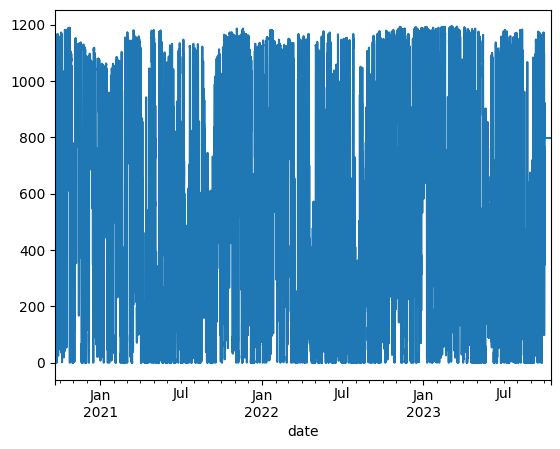

In [18]:
data_fe_filled.power_shifted_168.plot()

In [9]:
len(predictions)

168

In [ ]:
mae_gb = mean_absolute_error(y_test_filled, test_predictions)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 4)
y_test_filled.plot(label="y_test")
plt.ylabel('power')
pd.Series(power_predictions_filled, index=y_test_filled.index).plot(label="pred")
plt.title('Power')
plt.legend()
plt.show()

In [ ]:
#submission = pd.DataFrame(data=power_predictions_filled, columns=["power"])
#submission.to_csv("submission1", index=False)
#submission